#  Butterfly classifier system 


The dataset with butterflies that will be used is retrieved from (XXX). The dataset consisting of YY movie posters devided between YY folders, labelled YY.

In [1]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.models import Model  
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.python.tools import module_util as _module_util
from tensorflow.python.util.lazy_loader import LazyLoader as _LazyLoader
from tensorflow.python.eager import context
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
import tarfile
import time
%matplotlib inline
import random
import pickle
import json
from PIL import Image
from sklearn.manifold import TSNE
import matplotlib.pyplot
import pickle


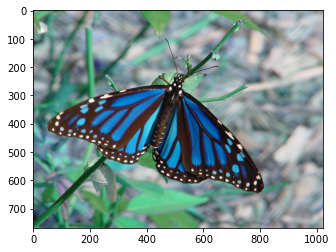

In [2]:
#Load the data and combine with categories
DATADIR = "C:/Users/Sabah Afzal/Butterfly_new_dataset"
CATEGORIES = ["001Danaus_plexippus", "002Heliconius_charitonius", "003Heliconius_erato","004Junonia_coenia","005Lycaena_phlaeas","006Nymphalis_antiopa","007Papilio_cresphontes","008Pieris_rapae","009Vanessa_atalanta","010Vanessa_cardui"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #path to the different categories
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        break
    break

In [3]:
#Use the pretrained convolutional neural network VGG16
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [4]:
#In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size.    
img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

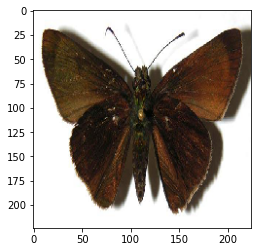

In [5]:
img, x = load_image("Butterfly_Dataset_Small/A1000/test.jpg")
plt.imshow(img)

In [6]:
# forward the image through the network and show the predictions
predictions = model.predict(x)
 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted lycaenid with probability 0.789
predicted ringlet with probability 0.210
predicted sulphur_butterfly with probability 0.001
predicted cabbage_butterfly with probability 0.000
predicted admiral with probability 0.000


In [7]:
#To use the model for feature extraction we remove the last layer (the classification layer)
#so that the final layer of the new network is the second 4096-neuron fully-connected layer "fc2"
feat_extractor_model = Model(inputs=model.input, outputs=model.get_layer("fc2").output)

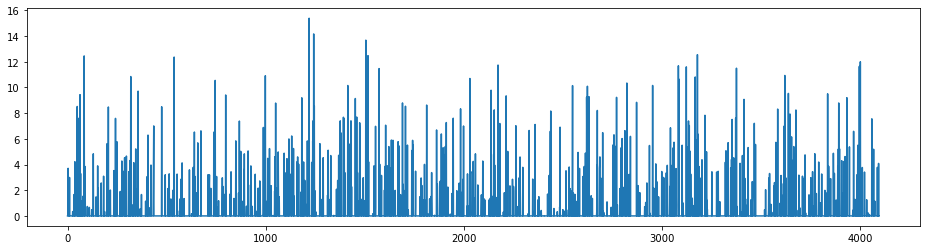

In [8]:
#The predict function returns an array with one element per image. Each element contains a 4096-element array
img, x = load_image("Butterfly_Dataset_Small/A1000/test.jpg")
feat = feat_extractor_model.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [9]:
#open a folder of images for analysis
images_path = 'Butterfly_new_dataset'
image_extensions = ['.jpg', '.png', '.jpeg']
max_num_images = 2000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1848 images to analyze


In [10]:
#begin a loop which will open each image, extract its feature vector, and append it to a list called 'features'
tic = time.process_time()

features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.process_time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.process_time()
    img, x = load_image(image_path);
    feat = feat_extractor_model.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 1848. Time: 0.0000 seconds.
analyzing image 500 / 1848. Time: 579.4688 seconds.
analyzing image 1000 / 1848. Time: 590.9531 seconds.
analyzing image 1500 / 1848. Time: 589.4844 seconds.
finished extracting features for 1848 images


In [11]:
#PCA is used to reduce the dimensionality from 4096 down to 300
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

In [12]:
#apply PCA on all the activation functions of the images
pca_features = pca.transform(features)

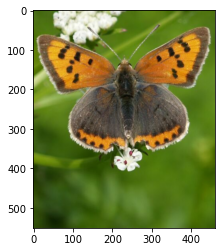

In [13]:
#Random image
query_image_idx = int(len(images) * random.random())

#Display image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

In [14]:
#Randomly select one image, and measures the distance of that image's PCA feature vector to all the other image's
from scipy.spatial import distance

#The distance is measured using 'Cosine Distance'
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [15]:
#"similar_idx" contains the image's similarity to every other one. 
#"idx_closest" sort the list after the most similar items, and return the indexes 2 most similar images
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:2]

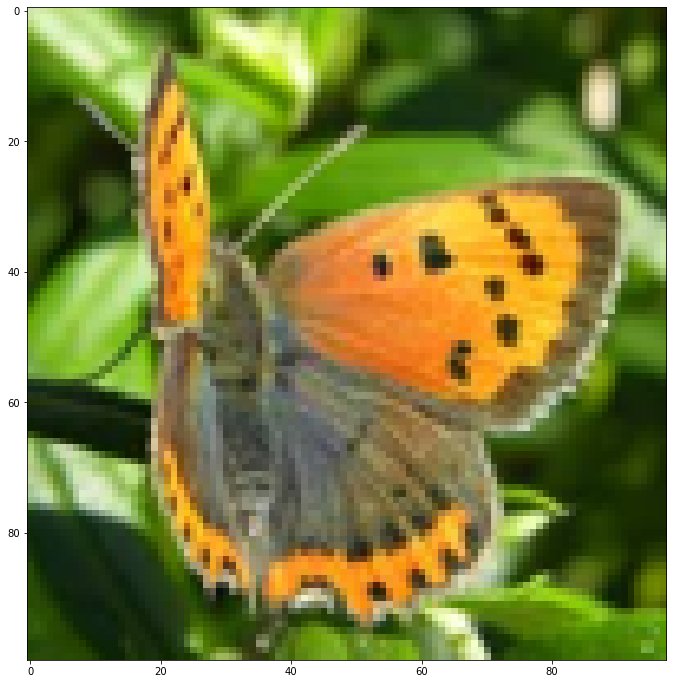

In [16]:
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

#concatenate the images
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

#show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [17]:
#functions to get the closest images to a query image
def get_closest_images(query_image_idx, num_results=2):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

#concatenate the images into one image
def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

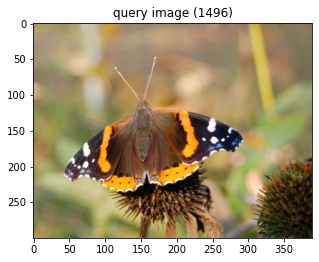

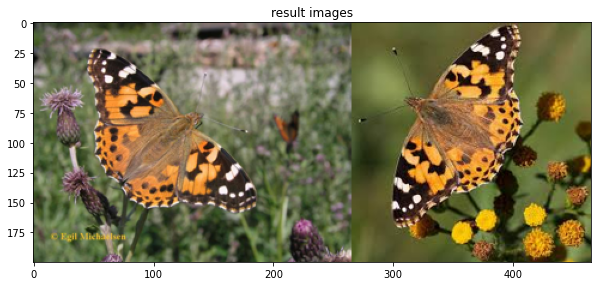

In [18]:
#run the functions
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)


plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)


plt.figure(figsize = (10,10))
plt.imshow(results_image)
plt.title("result images")

In [1]:
# load image and extract features
new_image, x = load_image("Butterfly_Dataset_Small/A1000/Test3.jpg")
new_features = feat_extractor_model.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:6]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (10,15))
plt.imshow(results_image)
plt.title("result images")

NameError: name 'load_image' is not defined

In [20]:
#Saves the work so far by using Pickle
pickle.dump([images, pca_features, pca], open('butterflyfeatures.pickle', 'wb'))

In [21]:
#Load in the work again
[images, pca_features, pca] = pickle.load(open('butterflyfeatures.pickle', 'rb'))

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(img, f[0], f[1], f[2], f[3]))

image: Butterfly_new_dataset\001Danaus_plexippus\0010001.png, features: 65.03,-60.39,14.63,-1.29... 
image: Butterfly_new_dataset\001Danaus_plexippus\0010002.png, features: 35.25,-52.30,10.18,19.77... 
image: Butterfly_new_dataset\001Danaus_plexippus\0010004.png, features: 36.82,-65.00,3.94,26.62... 
image: Butterfly_new_dataset\001Danaus_plexippus\0010005.png, features: 40.08,-69.00,8.39,26.90... 
image: Butterfly_new_dataset\001Danaus_plexippus\0010006.png, features: 90.46,-66.80,24.34,3.12... 


In [22]:
#apply t-SNE to the data and setting the components to 2 and the perplexity to 30.

#number of images to show on the t-SNE cloud
num_images_to_show = 1000

if len(images) > num_images_to_show:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_show))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [23]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=1000, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.035s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 16.070862
[t-SNE] Computed conditional probabilities in 0.062s
[t-SNE] Iteration 50: error = 80.3568726, gradient norm = 0.2175769 (50 iterations in 0.516s)
[t-SNE] Iteration 100: error = 80.4461288, gradient norm = 0.2191886 (50 iterations in 0.620s)
[t-SNE] Iteration 150: error = 80.4832230, gradient norm = 0.2136511 (50 iterations in 0.638s)
[t-SNE] Iteration 200: error = 78.2950516, gradient norm = 0.2291853 (50 iterations in 0.640s)
[t-SNE] Iteration 250: error = 78.6727448, gradient norm = 0.2172341 (50 iterations in 0.548s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.672745
[t-SNE] Iteration 300: error = 1.1345826, gradient norm = 0.0039314 (50 iterations in 0.453s)
[t-SNE] Iteration 350: error = 1.0200093, gradient norm = 0.0037

In [24]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

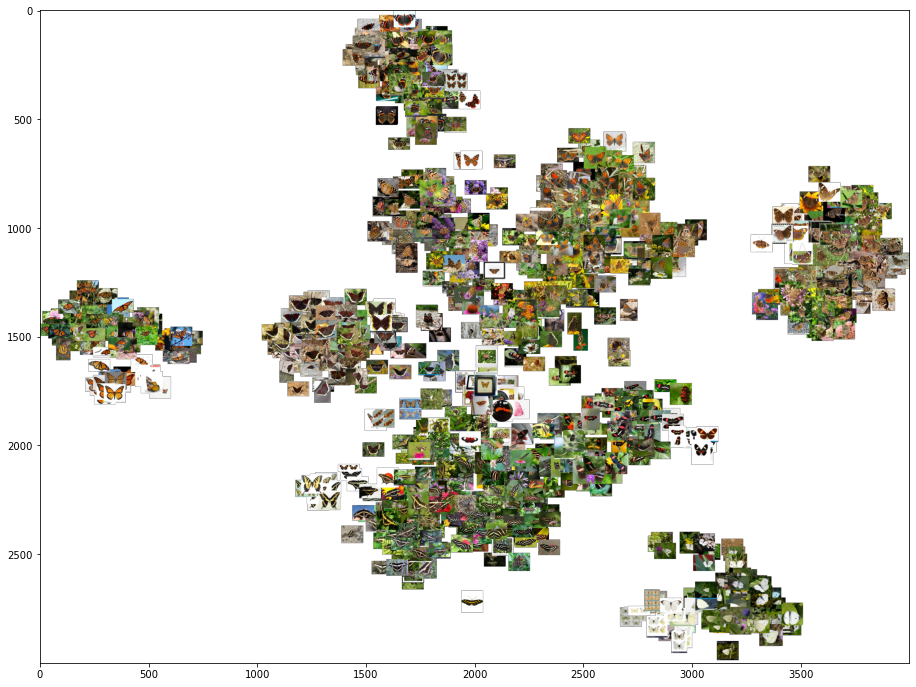

In [25]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [26]:
full_image.save("C:/Users/Sabah Afzal/example-tSNE-Butterflies-Perplexity30-learningrate100016.png")

In [27]:
tsne_path = "C:/Users/Sabah Afzal/example-tSNE-points-Butterflies1.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to C:/Users/Sabah Afzal/example-tSNE-points-Butterflies1.json


In [28]:
#Show the t-SNE cloud in a raster
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

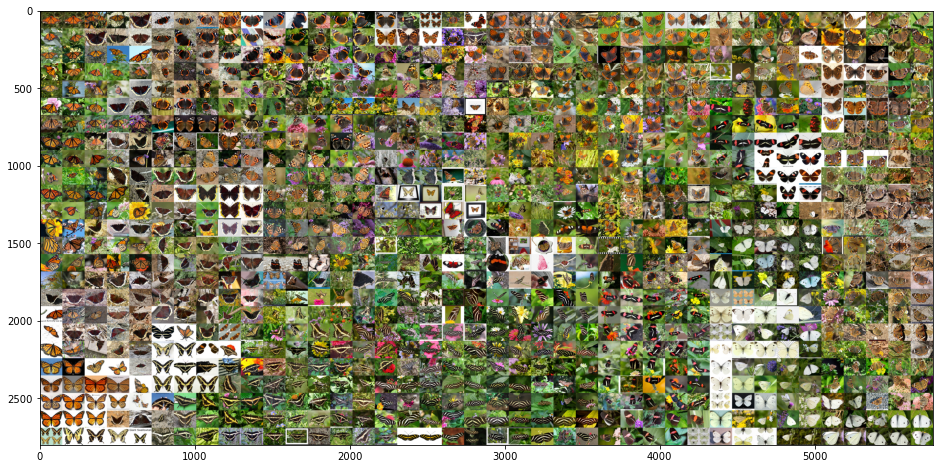

In [29]:
tile_width = 144
tile_height = 112

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [30]:
grid_image.save("C:/Users/Sabah Afzal/example-tSNE-Butterflies-grid201.png")